In [5]:
import re
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import numpy as np
from scipy.ndimage import uniform_filter1d

def load_texts(local_illiad: str = '../data/Homer_Iliad.txt',
               local_odyssey: str = '../data/Homer_Odyssey.txt'):
    """Load Illiad and Odyssey texts from disk.

    Parameters
    ----------
    local_illiad : str
        Path to Illiad text file. Defaults to '../data/Homer_Illiad.txt'.
    local_odyssey : str
        Path to Odyssey text file. Defaults to '../data/Homer_Odyssey.txt'.

    Returns
    -------
    tuple[str, str]
        (illiad_text, odyssey_text).

    Raises
    ------
    FileNotFoundError
        If either file is missing.
    """
    p1, p2 = Path(local_illiad), Path(local_odyssey)

    if not p1.exists():
        raise FileNotFoundError(
            f"Missing file: {p1}\n"
            "→ Please place 'Homer_Illiad.txt' at this path or update load_texts(...)."
        )
    if not p2.exists():
        raise FileNotFoundError(
            f"Missing file: {p2}\n"
            "→ Please place 'Homer_Odyssey.txt' at this path or update load_texts(...)."
        )

    iliad = p1.read_text(encoding='utf-8', errors='ignore')
    odyssey = p2.read_text(encoding='utf-8', errors='ignore')
    return iliad, odyssey

def normalize(text: str) -> str:
    """Normalize a Gutenberg-like text for tokenization."""
    if not text:
        return ''
    start = text.find('Translated by Samuel Butler')
    end = text.find('THE END')
    if start != -1 and end != -1 and end > start:
        text = text[start:end]
    return text.replace('\r\n', '\n')

iliad_raw, odyssey_raw = load_texts()
illiad = normalize(iliad_raw)
odyssey = normalize(odyssey_raw)

print(f"Illiad chars: {len(illiad):,} | Odyssey chars: {len(odyssey):,}")

Illiad chars: 806,725 | Odyssey chars: 609,794


In [6]:
WORD_RE = re.compile(r"[A-Za-z']+")

def words(text: str):
    """Simple word tokenizer (lowercased, ASCII letters + apostrophes)."""
    return WORD_RE.findall(text.lower())

def sentences(text: str):
    """Naive sentence splitter using punctuation boundaries."""
    return [s.strip() for s in re.split(r'(?<=[.!?])\s+', text) if s.strip()]

def find_word_contexts(text: str, word: str, context_chars: int = 100) -> list:
    """Find all occurrences of a word with surrounding context."""
    pattern = re.compile(rf'\b{word}\b', re.IGNORECASE)
    matches = []

    for match in pattern.finditer(text):
        start = max(0, match.start() - context_chars)
        end = min(len(text), match.end() + context_chars)
        context = text[start:end]
        matches.append(context)

    return matches

illiad_words = words(illiad)
odyssey_words = words(odyssey)
illiad_sentences = sentences(illiad)
odyssey_sentences = sentences(odyssey)

print(f"Illiad words: {len(illiad_words):,} | Odyssey words: {len(odyssey_words):,}")
print(f"Illiad sentences: {len(illiad_sentences):,} | Odyssey sentences: {len(odyssey_sentences):,}")


Illiad words: 153,277 | Odyssey words: 117,821
Illiad sentences: 4,201 | Odyssey sentences: 3,142


In [7]:
def load_color_list(path: str = '../data/colorWords.txt'):
    """Load color words from a text file (one per line)."""
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Missing color words file: {p}")
    text = p.read_text(encoding='utf-8', errors='ignore')
    colors = {line.strip().lower() for line in text.splitlines() if line.strip()}
    return colors

COLOR_LIST = load_color_list()
print(f"Loaded {len(COLOR_LIST)} color words from colorWords.txt")

def count_colors(tokens):
    c = Counter(w for w in tokens if w in COLOR_LIST)
    return c, sum(c.values()), len(tokens)

i_c, i_hits, i_total = count_colors(illiad_words)
o_c, o_hits, o_total = count_colors(odyssey_words)
print("Illiad top:", i_c.most_common(15), "| rate per 100k:", (i_hits/i_total)*100000)
print("Odyssey top:", o_c.most_common(15), "| rate per 100k:", (o_hits/o_total)*100000)

# Load once at the top of your notebook
nlp = spacy.load("en_core_web_sm")

def analyze_word_usage(text: str, target_word: str, max_examples: int = 50):
    """Analyze grammatical usage of a word using spaCy."""
    doc = nlp(text[:1000000])  # Limit to 1M chars to avoid memory issues

    adjective_uses = []
    noun_uses = []
    other_uses = []

    for token in doc:
        if token.text.lower() == target_word:
            # Adjectival modifier (e.g., "bronze armor")
            if token.dep_ == "amod":
                adjective_uses.append(f"{token.text} {token.head.text}")
            # Noun usage (e.g., "wrought in bronze")
            elif token.pos_ == "NOUN":
                # Get surrounding context
                start = max(0, token.i - 3)
                end = min(len(doc), token.i + 4)
                context = " ".join([t.text for t in doc[start:end]])
                noun_uses.append(context)
            else:
                # Other usage
                start = max(0, token.i - 3)
                end = min(len(doc), token.i + 4)
                context = " ".join([t.text for t in doc[start:end]])
                other_uses.append(context)

    print(f"=== Analysis of '{target_word}' ===")
    print(f"Adjective uses (modifying nouns): {len(adjective_uses)}")
    print(f"Noun uses (material references): {len(noun_uses)}")
    print(f"Other uses: {len(other_uses)}")
    print("\n--- Sample Adjective Uses (likely color) ---")
    for ex in adjective_uses[:max_examples]:
        print(f"  • {ex}")
    print("\n--- Sample Noun Uses (likely material) ---")
    for ex in noun_uses[:max_examples]:
        print(f"  • {ex}")

    return {
        'adjective': adjective_uses,
        'noun': noun_uses,
        'other': other_uses
    }

# Define material-ambiguous words to analyze
MATERIAL_WORDS = ["bronze", "golden", "silver", "iron", "steel", "copper", "brass", "gilt", "ivory", "amber"]

def analyze_all_material_words(text: str, material_words: list, max_examples: int = 10):
    """Analyze all material-ambiguous words and return summary statistics."""
    results = {}

    for word in material_words:
        print(f"\n{'='*60}")
        analysis = analyze_word_usage(text, word, max_examples=max_examples)

        # Store summary statistics
        total = len(analysis['adjective']) + len(analysis['noun']) + len(analysis['other'])
        if total > 0:
            adj_pct = (len(analysis['adjective']) / total) * 100
            noun_pct = (len(analysis['noun']) / total) * 100
            other_pct = (len(analysis['other']) / total) * 100

            results[word] = {
                'total': total,
                'adjective': len(analysis['adjective']),
                'noun': len(analysis['noun']),
                'other': len(analysis['other']),
                'adj_pct': adj_pct,
                'noun_pct': noun_pct,
                'other_pct': other_pct
            }

    return results


def rolling_color_windows(tokens, window=5000, step=500, color_list=None):
    """
    Calculate rolling window color word density with smoothing.

    Parameters:
    - tokens: list of words
    - window: size of rolling window (in words)
    - step: step size between windows
    - color_list: list of color words to track

    Returns:
    - list of dicts with start position, end position, color count, and rate per 100k
    """
    if color_list is None:
        color_list = COLOR_LIST

    hits_per_window = []

    for i in range(0, max(1, len(tokens) - window + 1), step):
        chunk = tokens[i:i + window]
        c = sum(1 for w in chunk if w in color_list)
        rate_per_100k = (c / window) * 100000 if window > 0 else 0

        hits_per_window.append({
            'start': i,
            'end': i + window,
            'count': c,
            'rate_per_100k': rate_per_100k
        })

    return hits_per_window


def smooth_density_curve(data, smoothing_factor=0.15):
    """
    Apply smoothing to density data using Gaussian-like filter.

    Parameters:
    - data: list of dicts with 'rate_per_100k' key
    - smoothing_factor: controls smoothing strength (0-1)

    Returns:
    - array of smoothed values
    """
    rates = np.array([d['rate_per_100k'] for d in data])

    # Calculate window size based on smoothing factor
    window_size = max(3, int(len(rates) * smoothing_factor))
    if window_size % 2 == 0:
        window_size += 1

    # Apply uniform filter for smoothing
    smoothed = uniform_filter1d(rates, size=window_size, mode='nearest')

    return smoothed

Loaded 20 color words from colorWords.txt
Illiad top: [('golden', 49), ('white', 26), ('black', 21), ('grey', 16), ('red', 16), ('purple', 9), ('pale', 7), ('yellow', 5), ('rosy', 5), ('green', 4), ('blue', 2), ('tawny', 2), ('scarlet', 1)] | rate per 100k: 106.34341747294116
Odyssey top: [('golden', 29), ('rosy', 20), ('black', 16), ('white', 14), ('grey', 11), ('blue', 8), ('green', 7), ('purple', 7), ('red', 5), ('pale', 5), ('yellow', 4), ('amber', 3), ('crimson', 2), ('tawny', 1)] | rate per 100k: 112.03435720287555


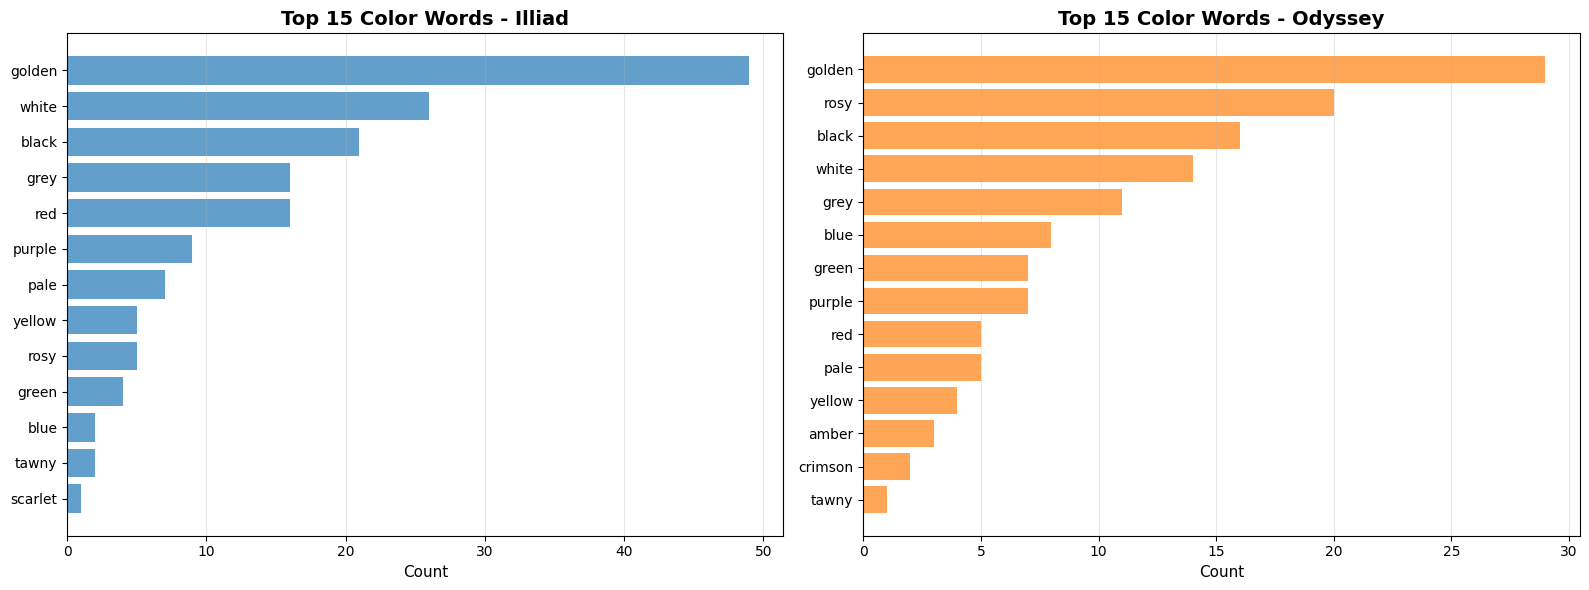

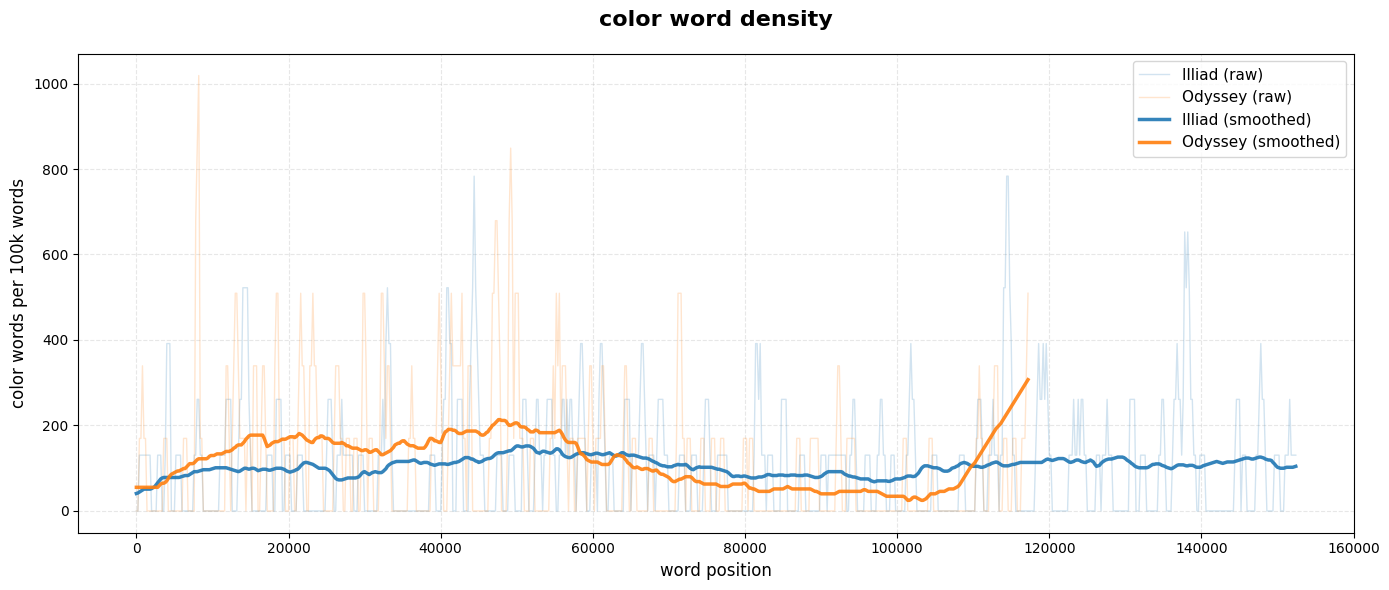

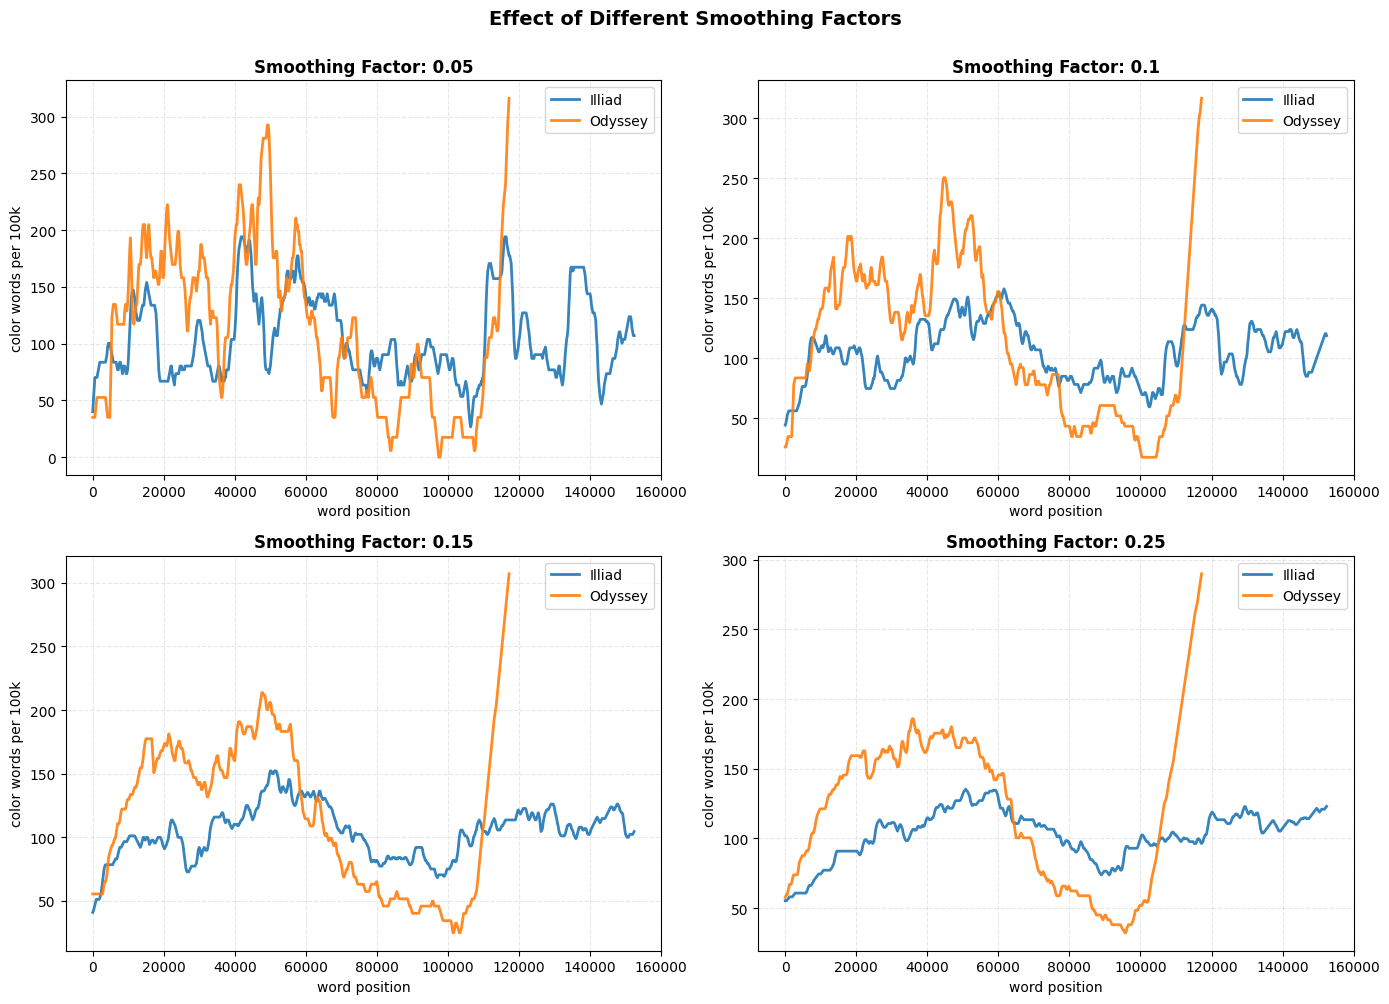

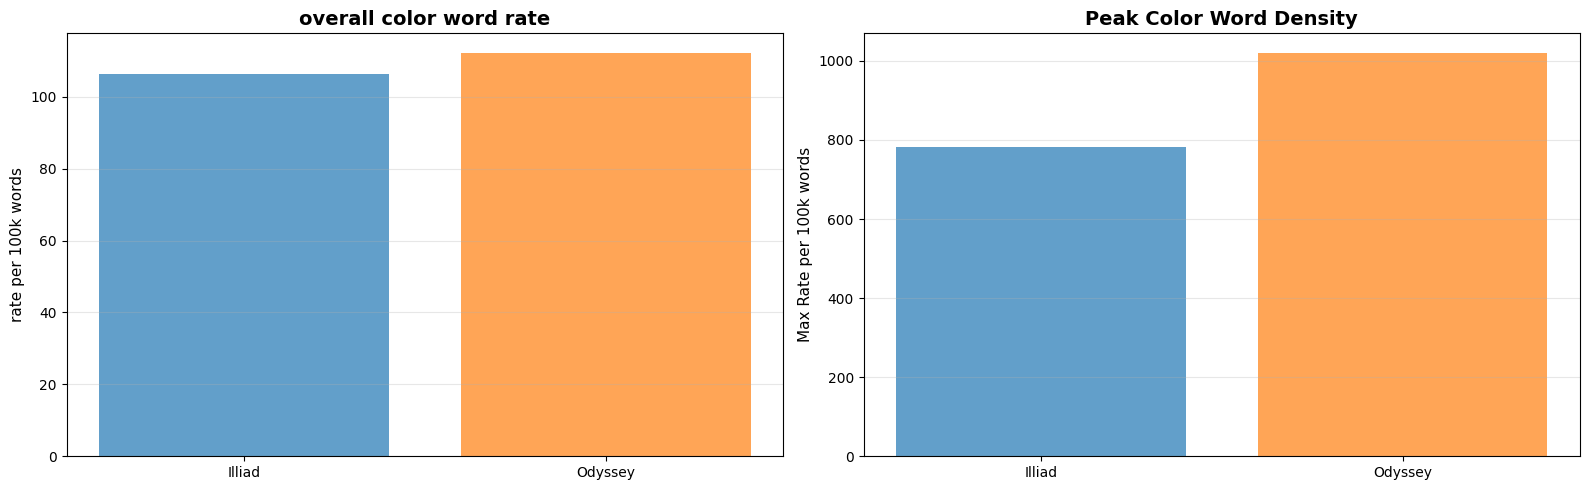

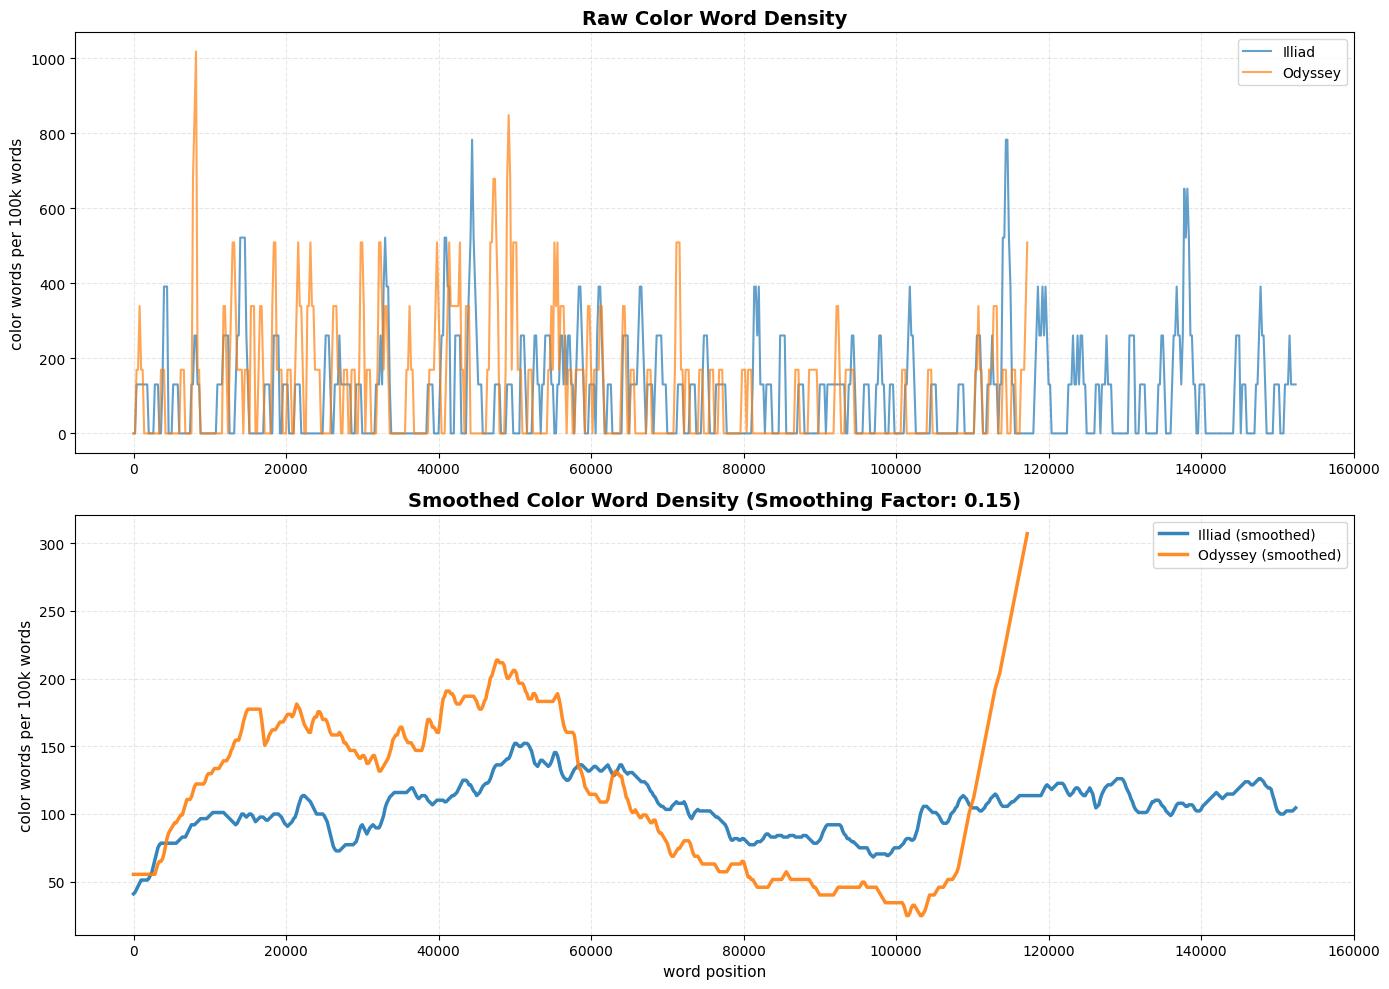


COLOR WORD DENSITY ANALYSIS - STATISTICS

--- OVERALL STATISTICS ---
Illiad Total Hits: 163 | Total Words: 153277
Odyssey Total Hits: 132 | Total Words: 117821

Illiad - Overall Rate: 106.34 per 100k words
Odyssey - Overall Rate: 112.03 per 100k words

--- ROLLING WINDOW STATISTICS (window=800, smoothing=0.15) ---
Illiad - Mean: 104.3 | Std: 19.9
Odyssey - Mean: 117.9 | Std: 60.5

Illiad - Peak: 152.1 at word position 50000
Odyssey - Peak: 307.1 at word position 117200

Illiad - Min: 40.9
Odyssey - Min: 24.8



'\n# Analyze both texts\nprint("ANALYZING ILIAD")\nprint("="*60)\niliad_results = analyze_all_material_words(illiad, MATERIAL_WORDS, max_examples=5)\n\nprint("\n\n" + "="*60)\nprint("ANALYZING ODYSSEY")\nprint("="*60)\nodyssey_results = analyze_all_material_words(odyssey, MATERIAL_WORDS, max_examples=5)\n\n# Create summary DataFrame\nsummary_data = []\nfor word in MATERIAL_WORDS:\n    iliad_data = iliad_results.get(word, {})\n    odyssey_data = odyssey_results.get(word, {})\n\n    summary_data.append({\n        \'Word\': word,\n        \'Iliad_Total\': iliad_data.get(\'total\', 0),\n        \'Iliad_Adj%\': round(iliad_data.get(\'adj_pct\', 0), 1),\n        \'Iliad_Noun%\': round(iliad_data.get(\'noun_pct\', 0), 1),\n        \'Odyssey_Total\': odyssey_data.get(\'total\', 0),\n        \'Odyssey_Adj%\': round(odyssey_data.get(\'adj_pct\', 0), 1),\n        \'Odyssey_Noun%\': round(odyssey_data.get(\'noun_pct\', 0), 1)\n    })\n\nsummary_df = pd.DataFrame(summary_data)\nprint("\n" + "="*60)

In [8]:
# ============= GENERATE ROLLING WINDOWS =============
# This ensures fair comparison regardless of text length
illiad_window = max(500, int(len(illiad_words) * 0.005))  # min 500 words
odyssey_window = max(500, int(len(odyssey_words) * 0.005))

illiad_step = max(200, int(illiad_window * 0.25))  # step = 25% of window
odyssey_step = max(200, int(odyssey_window * 0.25))

i_roll = rolling_color_windows(illiad_words, window=illiad_window, step=illiad_step)
o_roll = rolling_color_windows(odyssey_words, window=odyssey_window, step=odyssey_step)

# Create DataFrames
illiad_df = pd.DataFrame(i_roll, columns=['start', 'end', 'hits', 'rate_per_100k'])
odyssey_df = pd.DataFrame(o_roll, columns=['start', 'end', 'hits', 'rate_per_100k'])

# Apply smoothing
illiad_df['smoothed'] = smooth_density_curve(i_roll, smoothing_factor=0.15)
odyssey_df['smoothed'] = smooth_density_curve(o_roll, smoothing_factor=0.15)

# Top color words bar chart
i_top = pd.DataFrame(i_c.most_common(15), columns=['word', 'count'])
o_top = pd.DataFrame(o_c.most_common(15), columns=['word', 'count'])


# ============= PLOT 1: TOP 15 COLOR WORDS =============

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.barh(i_top['word'][::-1], i_top['count'][::-1], color='#1f77b4', alpha=0.7)
ax1.set_title('Top 15 Color Words - Illiad', fontsize=14, fontweight='bold')
ax1.set_xlabel('Count', fontsize=11)
ax1.grid(True, alpha=0.3, axis='x')

ax2.barh(o_top['word'][::-1], o_top['count'][::-1], color='#ff7f0e', alpha=0.7)
ax2.set_title('Top 15 Color Words - Odyssey', fontsize=14, fontweight='bold')
ax2.set_xlabel('Count', fontsize=11)
ax2.grid(True, alpha=0.3, axis='x')

plt.savefig("../results/figures/CW_Color_words_bar_chart.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()
plt.close()


# ============= PLOT 2: ROLLING AVERAGE WITH SMOOTHING =============

fig, ax = plt.subplots(figsize=(14, 6))

# Plot raw data (lighter)
ax.plot(illiad_df['start'], illiad_df['rate_per_100k'],
        color='#1f77b4', alpha=0.2, linewidth=1, label='Illiad (raw)')
ax.plot(odyssey_df['start'], odyssey_df['rate_per_100k'],
        color='#ff7f0e', alpha=0.2, linewidth=1, label='Odyssey (raw)')

# Plot smoothed curves (bold)
ax.plot(illiad_df['start'], illiad_df['smoothed'],
        color='#1f77b4', linewidth=2.5, label='Illiad (smoothed)', alpha=0.9)
ax.plot(odyssey_df['start'], odyssey_df['smoothed'],
        color='#ff7f0e', linewidth=2.5, label='Odyssey (smoothed)', alpha=0.9)

ax.set_title('color word density', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('word position', fontsize=12)
ax.set_ylabel('color words per 100k words', fontsize=12)
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3, linestyle='--')

plt.savefig("../results/figures/CW_Color_words_combine_line_plot.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()
plt.close()


# ============= PLOT 3: SMOOTHING FACTOR COMPARISON =============

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
smoothing_factors = [0.05, 0.10, 0.15, 0.25]

for idx, smooth_factor in enumerate(smoothing_factors):
    ax = axes[idx // 2, idx % 2]

    i_smooth = smooth_density_curve(i_roll, smoothing_factor=smooth_factor)
    o_smooth = smooth_density_curve(o_roll, smoothing_factor=smooth_factor)

    ax.plot(illiad_df['start'], i_smooth, color='#1f77b4', linewidth=2, label='Illiad', alpha=0.9)
    ax.plot(odyssey_df['start'], o_smooth, color='#ff7f0e', linewidth=2, label='Odyssey', alpha=0.9)

    ax.set_title(f'Smoothing Factor: {smooth_factor}', fontweight='bold', fontsize=12)
    ax.set_xlabel('word position', fontsize=10)
    ax.set_ylabel('color words per 100k', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=10)

plt.suptitle('Effect of Different Smoothing Factors', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig("../results/figures/CW_Color_words_smoothing_comparison.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()


# ============= PLOT 4: SUMMARY STATISTICS =============

summary_df = pd.DataFrame({
    'Text': ['Illiad', 'Odyssey'],
    'Mean Rate': [illiad_df['rate_per_100k'].mean(), odyssey_df['rate_per_100k'].mean()],
    'Max Rate': [illiad_df['rate_per_100k'].max(), odyssey_df['rate_per_100k'].max()],
    'Overall Rate': [(i_hits/i_total)*100000, (o_hits/o_total)*100000]
})

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(16, 5))

# Overall rate comparison
ax1.bar(summary_df['Text'], summary_df['Overall Rate'], color=['#1f77b4', '#ff7f0e'], alpha=0.7)
ax1.set_title('overall color word rate', fontsize=14, fontweight='bold')
ax1.set_ylabel('rate per 100k words', fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

# Max rate comparison
ax3.bar(summary_df['Text'], summary_df['Max Rate'], color=['#1f77b4', '#ff7f0e'], alpha=0.7)
ax3.set_title('Peak Color Word Density', fontsize=14, fontweight='bold')
ax3.set_ylabel('Max Rate per 100k words', fontsize=11)
ax3.grid(True, alpha=0.3, axis='y')

plt.savefig("../results/figures/CW_Color_words_Overall_Mean_Max_rate_comparison.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()
plt.close()


# ============= PLOT 5: DETAILED COMPARISON - RAW VS SMOOTHED =============

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Raw data
ax1.plot(illiad_df['start'], illiad_df['rate_per_100k'],
         color='#1f77b4', linewidth=1.5, label='Illiad', alpha=0.7)
ax1.plot(odyssey_df['start'], odyssey_df['rate_per_100k'],
         color='#ff7f0e', linewidth=1.5, label='Odyssey', alpha=0.7)
ax1.set_title('Raw Color Word Density', fontsize=14, fontweight='bold')
ax1.set_ylabel('color words per 100k words', fontsize=11)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')

# Smoothed data
ax2.plot(illiad_df['start'], illiad_df['smoothed'],
         color='#1f77b4', linewidth=2.5, label='Illiad (smoothed)', alpha=0.9)
ax2.plot(odyssey_df['start'], odyssey_df['smoothed'],
         color='#ff7f0e', linewidth=2.5, label='Odyssey (smoothed)', alpha=0.9)
ax2.set_title('Smoothed Color Word Density (Smoothing Factor: 0.15)', fontsize=14, fontweight='bold')
ax2.set_xlabel('word position', fontsize=11)
ax2.set_ylabel('color words per 100k words', fontsize=11)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig("../results/figures/CW_Color_words_raw_vs_smoothed.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()


# ============= STATISTICS PRINTOUT =============

print("\n" + "="*60)
print("COLOR WORD DENSITY ANALYSIS - STATISTICS")
print("="*60)

print("\n--- OVERALL STATISTICS ---")
print(f"Illiad Total Hits: {i_hits} | Total Words: {i_total}")
print(f"Odyssey Total Hits: {o_hits} | Total Words: {o_total}")

print(f"\nIlliad - Overall Rate: {(i_hits/i_total)*100000:.2f} per 100k words")
print(f"Odyssey - Overall Rate: {(o_hits/o_total)*100000:.2f} per 100k words")

print("\n--- ROLLING WINDOW STATISTICS (window=800, smoothing=0.15) ---")
print(f"Illiad - Mean: {illiad_df['smoothed'].mean():.1f} | Std: {illiad_df['smoothed'].std():.1f}")
print(f"Odyssey - Mean: {odyssey_df['smoothed'].mean():.1f} | Std: {odyssey_df['smoothed'].std():.1f}")

print(f"\nIlliad - Peak: {illiad_df['smoothed'].max():.1f} at word position {illiad_df.loc[illiad_df['smoothed'].idxmax(), 'start']:.0f}")
print(f"Odyssey - Peak: {odyssey_df['smoothed'].max():.1f} at word position {odyssey_df.loc[odyssey_df['smoothed'].idxmax(), 'start']:.0f}")

print(f"\nIlliad - Min: {illiad_df['smoothed'].min():.1f}")
print(f"Odyssey - Min: {odyssey_df['smoothed'].min():.1f}")

print("\n" + "="*60)






"""
Testing grounds for color words that could also be materials every test could be run to make sure that these words are being used in the correct context.
"""
"""
# Check "bronze" usage
bronze_contexts = find_word_contexts(illiad, "bronze", context_chars=80)
print(f"Found {len(bronze_contexts)} instances of 'bronze':\n")
for i, ctx in enumerate(bronze_contexts[:20], 1):  # Show first 5
    print(f"{i}. ...{ctx}...\n")
"""
"""
# Analyze both texts
print("ANALYZING ILIAD")
print("="*60)
iliad_results = analyze_all_material_words(illiad, MATERIAL_WORDS, max_examples=5)

print("\n\n" + "="*60)
print("ANALYZING ODYSSEY")
print("="*60)
odyssey_results = analyze_all_material_words(odyssey, MATERIAL_WORDS, max_examples=5)

# Create summary DataFrame
summary_data = []
for word in MATERIAL_WORDS:
    iliad_data = iliad_results.get(word, {})
    odyssey_data = odyssey_results.get(word, {})

    summary_data.append({
        'Word': word,
        'Iliad_Total': iliad_data.get('total', 0),
        'Iliad_Adj%': round(iliad_data.get('adj_pct', 0), 1),
        'Iliad_Noun%': round(iliad_data.get('noun_pct', 0), 1),
        'Odyssey_Total': odyssey_data.get('total', 0),
        'Odyssey_Adj%': round(odyssey_data.get('adj_pct', 0), 1),
        'Odyssey_Noun%': round(odyssey_data.get('noun_pct', 0), 1)
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*60)
print("SUMMARY: Material Word Usage Patterns")
print("="*60)
print(summary_df.to_string(index=False))

# Visualize the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Iliad material word usage
iliad_df = summary_df[summary_df['Iliad_Total'] > 0].copy()
iliad_df = iliad_df.sort_values('Iliad_Total', ascending=True)

ax1.barh(iliad_df['Word'], iliad_df['Iliad_Adj%'], label='Adjective (likely color)', alpha=0.7)
ax1.barh(iliad_df['Word'], iliad_df['Iliad_Noun%'], left=iliad_df['Iliad_Adj%'],
         label='Noun (likely material)', alpha=0.7)
ax1.set_title('Material/Color Word Usage - Iliad', fontsize=14, fontweight='bold')
ax1.set_xlabel('Percentage', fontsize=11)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# Odyssey material word usage
odyssey_df = summary_df[summary_df['Odyssey_Total'] > 0].copy()
odyssey_df = odyssey_df.sort_values('Odyssey_Total', ascending=True)

ax2.barh(odyssey_df['Word'], odyssey_df['Odyssey_Adj%'], label='Adjective (likely color)', alpha=0.7)
ax2.barh(odyssey_df['Word'], odyssey_df['Odyssey_Noun%'], left=odyssey_df['Odyssey_Adj%'],
         label='Noun (likely material)', alpha=0.7)
ax2.set_title('Material/Color Word Usage - Odyssey', fontsize=14, fontweight='bold')
ax2.set_xlabel('Percentage', fontsize=11)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig("../results/figures/CW_Material_word_analysis.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# Decision helper
print("\n" + "="*60)
print("RECOMMENDATIONS:")
print("="*60)
for _, row in summary_df.iterrows():
    if row['Iliad_Total'] == 0 and row['Odyssey_Total'] == 0:
        continue

    avg_noun = (row['Iliad_Noun%'] + row['Odyssey_Noun%']) / 2

    if avg_noun > 80:
        print(f"❌ REMOVE '{row['Word']}' - {avg_noun:.1f}% material usage")
    elif avg_noun < 20:
        print(f"✓ KEEP '{row['Word']}' - {100-avg_noun:.1f}% color usage")
    else:
        print(f"⚠ AMBIGUOUS '{row['Word']}' - {avg_noun:.1f}% material, {100-avg_noun:.1f}% color")"""